# Setup

**Imports**

In [113]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from ruptures.base import BaseCost
from ruptures.metrics import hausdorff

import seaborn as sns

from tqdm import tqdm
import geopandas

rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [24]:
# path to data files
# 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# changer ici avec le path dans ton repo 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

datapath = "/home/benjamin/Folders_Python/MVA/AST_TP3/data/"

In [25]:
FS = 22050  # sampling frequency (Hz)

X_train_filepath = datapath + "X_train.npy"
y_train_filepath = datapath + "y_train.npy"

X_train = np.load(X_train_filepath, allow_pickle=True).tolist()
y_train = np.load(y_train_filepath, allow_pickle=True).tolist()

In [26]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


In [27]:
def return_symbol(f1,f2):
    """retourne le symbole correspondant aux deux fréquences f1 et f2
    """
    
    fmin = int(np.min([f1,f2]))
    fmax = int(np.max([f1,f2]))
    
    dico = {
        "1" : [697,1209],
        "2" : [697,1336],
        "3" : [697, 1477],
        "A" : [697, 1633],
        "4" : [770, 1209],
        "5" : [770, 1336],
        "6" : [770, 1477],
        "B" : [770, 1633],
        "7" : [852, 1209],
        "8" : [852, 1336],
        "9" : [852, 1477],
        "C" : [852, 1633],
        "*" : [941, 1209],
        "0" : [941, 1336],
        "#" : [941, 1477],
        "D" : [941, 1633]
    }
    
    for k,v in dico.items():
        if v == [fmin, fmax]:
            return k
    print(f'no key corresponding to {fmin, fmax}')
    return None

### Validating a pipeline

The time representation is pretty useless

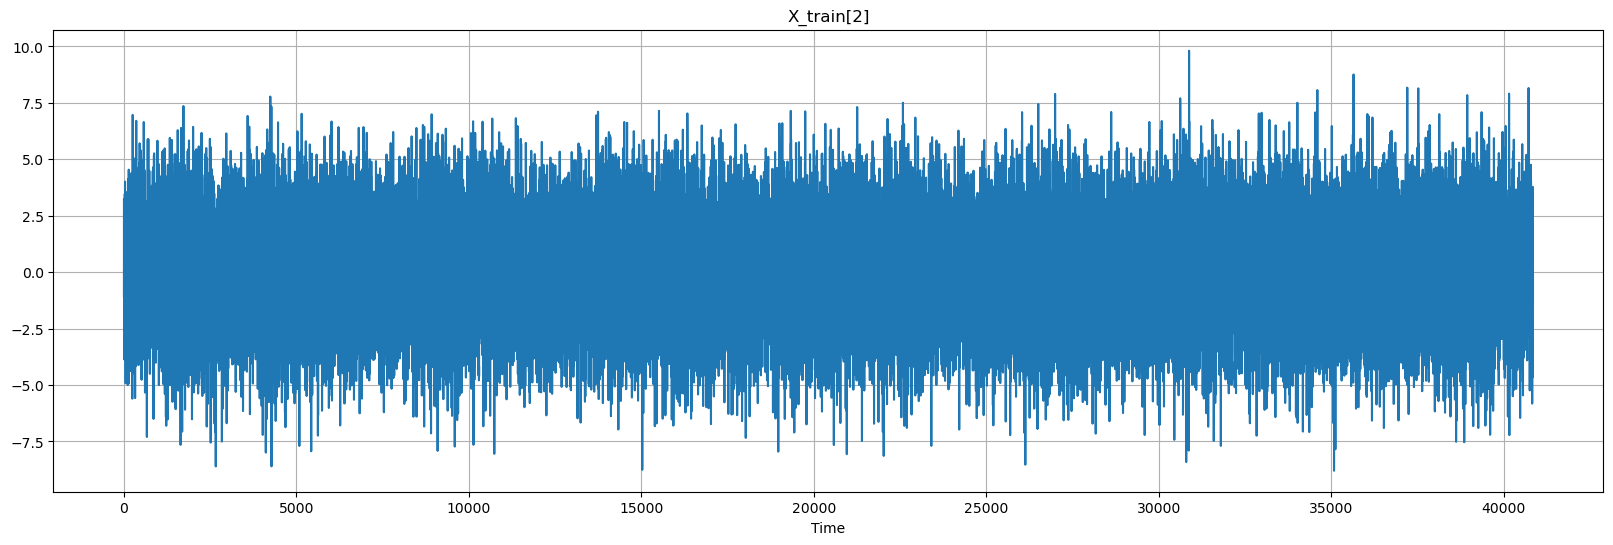

In [28]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(signal)
ax.grid(True)
ax.set_title("X_train[2]")
ax.set_xlabel('Time')
plt.show()

Let's plot the spectrogram : we can see 10 pairs, separated by silences, and an added noise whose frequency varies as a sine.

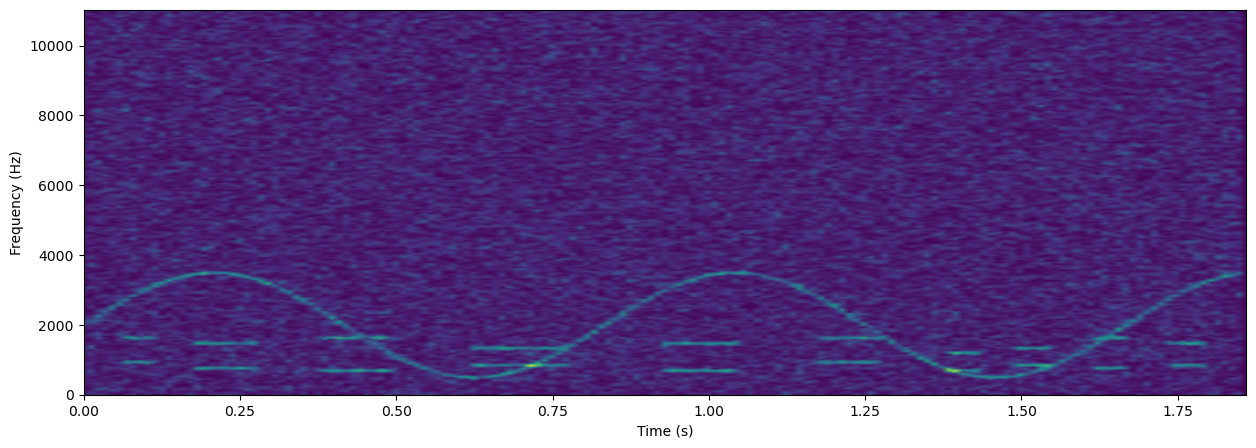

In [29]:
from scipy.signal import stft
FREQUENCY = 22050

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=500, noverlap=None)

fig, ax = fig_ax()
ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

In [30]:
print(f'signal = {signal.shape}')
print(f't = {t.shape} fenêtres')
print(f'f = {f.shape} frequences par DFT')
print(f'|Zxx| = {np.abs(Zxx).shape}')

signal = (40847,)
t = (165,) fenêtres
f = (251,) frequences par DFT
|Zxx| = (251, 165)


In [31]:
# first, filter around frequencies of interest

foi = [697, 770, 852, 941, 1209,1336, 1477, 1633]  # frequencies of interest
tolerance = 0

In [32]:
def extract_Zxx_net(Zxx):
    
    # extract data for frequencies of interest
    Zxx_net = np.zeros(shape=Zxx.shape)
    for i,freq in enumerate(foi):
        id_low = np.argwhere(f <= (freq-tolerance))[-1][0]
        id_high = np.argwhere(f >= (freq+tolerance))[0][0]
        nb_ind = id_high - id_low +1
        if i==0:
            Zxx_net = Zxx[id_low:id_high+1,:]
            freq_display = f[id_low:id_high+1]
        else:
            Zxx_net = np.concatenate( [Zxx_net, Zxx[id_low:id_high+1,:]], axis=0)
            freq_display = np.concatenate( [freq_display, f[id_low:id_high+1]], axis=0)
            
    return Zxx_net, freq_display

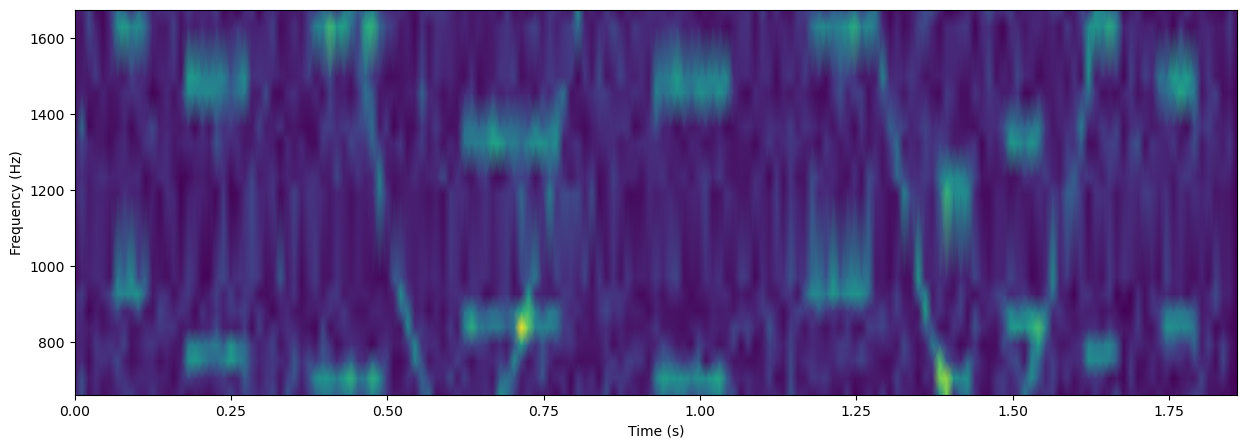

In [33]:
Zxx_net = np.zeros(shape=Zxx.shape)
Zxx_net, freq_display = extract_Zxx_net(Zxx)

fig, ax = fig_ax()
ax.pcolormesh(t, freq_display, np.abs(Zxx_net), vmin=0, shading="gouraud")
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Frequency (Hz)")

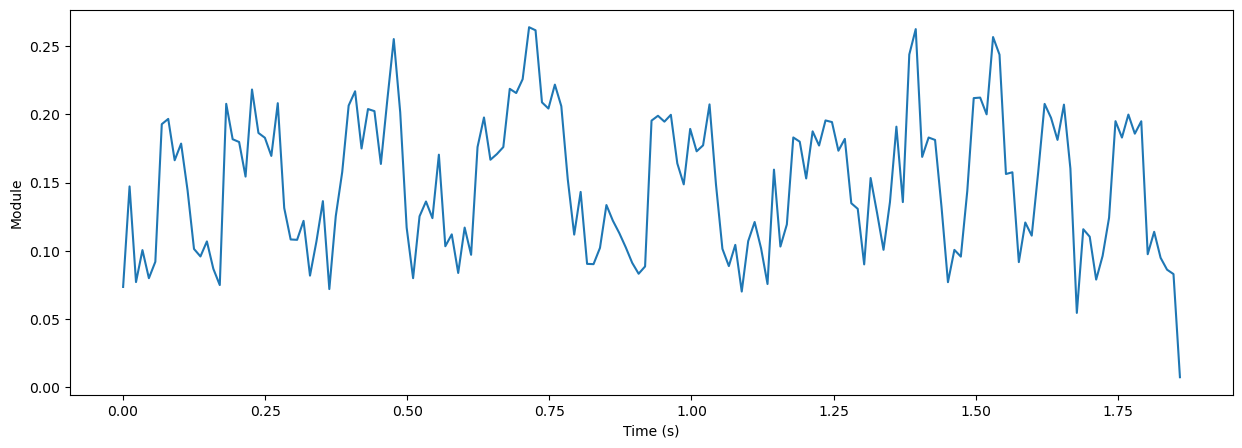

In [34]:
# plot average energy per window

avg_nrj = np.mean(np.abs(Zxx_net), axis=0).reshape(-1,)

fig, ax = fig_ax()
ax.plot(t,avg_nrj)
ax.set_xlabel("Time (s)")
_ = ax.set_ylabel("Module")

Found 21 break points vs 10 symboles


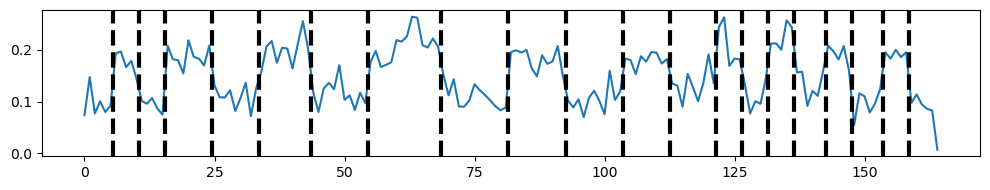

In [35]:
# Now, use change-point detection algorithm on average value, with BIC criterion, to separate silences from dial-tones

# noise_std = np.std(avg_nrj)/2
# noise_std = np.mean(np.std(np.abs(Zxx_net), axis=0))

noise_std = 0.03 # how to optimize ?
pen_bic = 2 * np.log(len(avg_nrj)) * noise_std**2
signal = avg_nrj.reshape(-1,1)

predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal, pen=pen_bic)
print(f'Found {len(predicted_bkps)} break points vs {len(symbols)} symboles')

fig, ax_arr = rpt.display(signal, [], predicted_bkps)
# print(f"error: {hausdorff([], predicted_bkps)} samples")

In [36]:
def predict_symbols(Z_net, pred_bkps):
    
    # loop over segments and classify
    i_min = 0
    signal_threshold = np.mean(np.abs(Z_net))  # average enegy above which there is a dial tone, under which this is silence
    list_symbols = []

    for i_max in pred_bkps:
        nrj = np.mean(np.abs(Z_net[:,i_min:i_max]))
        # print(f'Looking at segment {i_min},{i_max} : nrj = {nrj}')
        if nrj <= signal_threshold:
            # print(f'segment between {i_min},{i_max} : silence')
            pass
        else:
            # il y a un signal
            list_freqs = []
            for j, freq in enumerate(foi):
                nrj_freq = np.mean(np.abs(Z_net[j*2:j*2+1,i_min:i_max]))
                if nrj_freq > signal_threshold:
                    # {i_min},{i_max} : 
                    # print(f'Frequence {freq} is active dans segment {i_min},{i_max}')
                    list_freqs.append(freq)
            if len(list_freqs) <= 1:
                msg = f"une seule fréquence active trouvée dans une bande d'énergie!"
            if len(list_freqs) == 2:
                symbole = return_symbol(list_freqs[0], list_freqs[1])
                msg = f"symbole trouvé = {symbole}"
            if len(list_freqs) >= 3:
                symbole = return_symbol(np.min(list_freqs), np.max(list_freqs))
                msg = f"Trois fréquences actives trouvées ou plus - symbole choisi random : {symbole} avec {np.min(list_freqs)} et {np.max(list_freqs)}"
            # print(f'segment between {i_min},{i_max} : ' + msg)
            list_symbols.append(symbole)
            
        i_min = i_max
        
    return list_symbols

In [37]:
print(f"\n")
print(f"Ground truth = {symbols}")
list_symbols = predict_symbols(Z_net=Zxx_net, pred_bkps=predicted_bkps)
print(f"Prediction = {list_symbols}")



Ground truth = ['D', '6', 'A', '8', '3', 'D', '1', '8', 'B', '9']
Prediction = ['D', '6', 'A', '8', '3', 'D', '1', '2', 'B', '9']


### Optimizing hyperparameters

Hyperparameters to otpimize :
- nperseg dans STFT
- noise_std dans BIC pour PELT

Metric :
- nombre de break points, doit proche du nombre de symboles ground truth x 2 + 1

In [38]:
foi = [697, 770, 852, 941, 1209,1336, 1477, 1633]  # frequencies of interest
tolerance = 0

results = {}

list_nperseg = np.linspace(100, 2000, endpoint=True, num=3)  # put num=20 to recover results in report, but beware of computation time
print(f"nprseg : {list_nperseg}")
list_noise_std = np.linspace(0.01, 0.05, endpoint=True, num=3) # put num=20 to recover results in report, but beware of computation time
print(f"noise_std = {list_noise_std}")

nprseg : [ 100. 1050. 2000.]
noise_std = [0.01 0.03 0.05]


In [39]:
xp = 0
xp_total = len(list_nperseg) * len(list_noise_std)

for nperseg in list_nperseg:
    for noise_std in list_noise_std:
        
        # print(f"Training for nperseg = {nperseg}, noise_std = {noise_std}")
        print(f"Running xp {xp+1} / {xp_total}", end="\r")
        
        list_errors = []
        for n, (signal, symbols) in enumerate(zip(X_train, y_train)):
            
            # for debug purposes
            # ------------------
            # if i%20 == 0:
            #     print(f"i = {i}")
            #     print(f"signal = {signal}")
            #     print(f"{signal.shape}")
            #     print(f"symbols = {symbols}")
            
            # calculate spectrogram
            f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=nperseg, noverlap=None)
            
            # extract data for frequencies of interest
            Zxx_net, freq_display = extract_Zxx_net(Zxx)
            
            # run change-point detection on energy signal for frequencies of interest
            avg_nrj = np.mean(np.abs(Zxx_net), axis=0).reshape(-1,)
            pen_bic = 2 * np.log(len(avg_nrj)) * noise_std**2
            signal_2 = avg_nrj.reshape(-1,1)
            predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal_2, pen=pen_bic)
            
            # absolute error between predicted number of break points and target
            list_errors.append(np.abs(len(predicted_bkps) - (2*len(symbols)+1)))
            
        # log results
        results[xp] = [nperseg, noise_std, list_errors]
        xp += 1

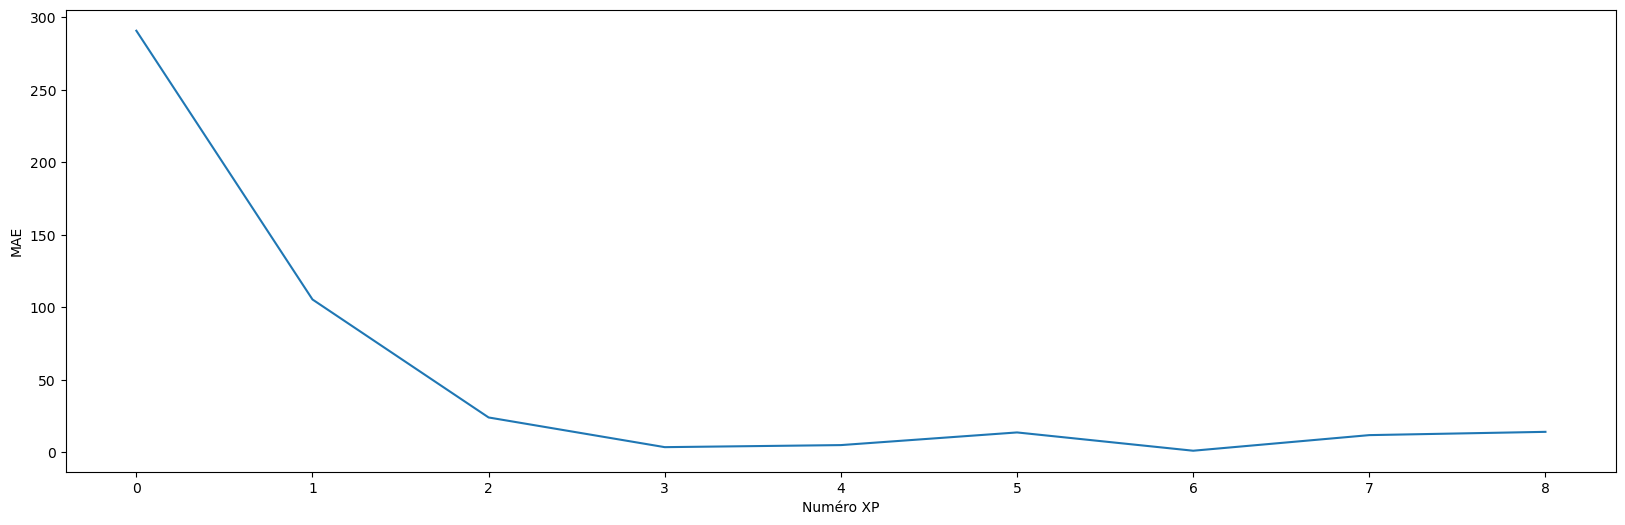

In [40]:
# plotting best results

mean_results = { xp : [ v[0], v[1], np.mean(v[2])] for xp, v in results.items()}

scores = np.zeros(shape=(len(mean_results)))
for i in range(len(mean_results)):
    scores[i] = mean_results.get(i)[2]
    
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(scores)
ax.set_xlabel(f"Numéro XP")
ax.set_ylabel(f"MAE")

best = np.argmin(scores)

In [41]:
# best hyperparameters
# best_nperseg = results.get(best)[0]   # NB : best_nperseg = 900
# best_noise_std = results.get(best)[1]  # NB : best_noise_std = 0.0205

# values found after grid search with num=20 x 2
# best = 165
best_nperseg = 900
best_noise_std = 0.0205

print(f"Best XP is number {best}, with nperseg = {best_nperseg}, noise_std = {best_noise_std}, MAE = {scores[best]}")

Best XP is number 6, with nperseg = 900, noise_std = 0.0205, MAE = 1.2


In [42]:
# check hyperparameters on random signals in dataset
N = 10
id_random_samples = np.random.choice(range(len(X_train)), size=N)

for id in id_random_samples:
    
    # get sample
    signal, gt_symbols = X_train[id], y_train[id]
    
    # calculate spectrogram
    f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=best_nperseg, noverlap=None)
    
    # extract data for frequencies of interest
    Zxx_net, freq_display = extract_Zxx_net(Zxx)
    
    # run change-point detection on energy signal for frequencies of interest
    avg_nrj = np.mean(np.abs(Zxx_net), axis=0).reshape(-1,)
    pen_bic = 2 * np.log(len(avg_nrj)) * best_noise_std**2
    signal_2 = avg_nrj.reshape(-1,1)
    predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal_2, pen=pen_bic)
    
    # check
    print(f"\n")
    print(f"Ground truth = {gt_symbols}")
    list_symbols = predict_symbols(Z_net=Zxx_net, pred_bkps=predicted_bkps)
    print(f"Prediction = {list_symbols}")   




Ground truth = ['2', '2', '9', '4', '9', '2', '3', 'A', 'B', '4']
Prediction = ['2', '3', '9', '4', '9', '2', '2', '3', 'A', 'A', '1']


Ground truth = ['9', '4', '1']
Prediction = ['6', '4', '1']


Ground truth = ['7', 'C', '0', '8', '7', '0', '*', '8', '3', '2', 'B']
Prediction = ['7', 'C', '#', '8', '7', '0', '1', '8', '3', '2', 'B']


Ground truth = ['2', '1', '2', '4', '1', '0', '#', 'D', 'D']
Prediction = ['2', '1', '2', '4', '3', '0', '#', 'D', 'D']


Ground truth = ['7', '9', '0', 'D', 'C', '3', 'A']
Prediction = ['7', '9', '2', 'D', 'C', 'A', 'A']


Ground truth = ['0', '9', '6', 'C', '#', '3', '4', 'B', '#', '1']
Prediction = ['0', '9', '6', 'C', '#', 'A', '#', '1']


Ground truth = ['1', '2', '*', '3', '8', '1', '9']
Prediction = ['1', '3', '1', '*', '3', '8', '1', '3']


Ground truth = ['4', 'A', '*', '4', '7', '8', 'C']
Prediction = ['4', 'A', '4', '4', '7', '2', 'C']


Ground truth = ['0', 'C', '3', '8', '3', '*']
Prediction = ['0', 'B', '3', 'A', '8', '3', '4']


Groun

# Question 2

In [43]:
X_test_filepath = datapath + "X_test.npy"

X_test = np.load(X_test_filepath, allow_pickle=True).tolist()

In [44]:
for signal in X_test:
          
    # calculate spectrogram
    f, t, Zxx = stft(signal, fs=FREQUENCY, nperseg=best_nperseg, noverlap=None)
    
    # extract data for frequencies of interest
    Zxx_net, freq_display = extract_Zxx_net(Zxx)
    
    # run change-point detection on energy signal for frequencies of interest
    avg_nrj = np.mean(np.abs(Zxx_net), axis=0).reshape(-1,)
    pen_bic = 2 * np.log(len(avg_nrj)) * best_noise_std**2
    signal_2 = avg_nrj.reshape(-1,1)
    predicted_bkps = rpt.Pelt(model="l2", jump=1).fit_predict(signal=signal_2, pen=pen_bic) 
        
    print(f"\n")
    list_symbols = predict_symbols(Z_net=Zxx_net, pred_bkps=predicted_bkps)
    print(f"Prediction = {list_symbols}")



Prediction = ['7', '2', '3', '9', '6']


Prediction = ['1', '#', '2', '#']


# Question 3

Definition du Kernel

In [45]:
def g_U(lambd, a, R):
    """Per overleaf

    Args:
        lambd (float): input
        a (float) : parameter
        R (float) : parameter
    """
    
    assert R>0, f"Parameter R is negative - got {R}"
    
    if lambd >= 0 or lambd < -R*a:
        return 0
    else:
        return 1/2 * (1 + np.cos(2*np.pi*(1/2 + lambd/(a*R))))

In [46]:
def g_m(lambd, a, m, R):
    """per overleaf

    Args:
        lambd (float): parameter
        a (float): parameter
        m (float): parameter
        R (float): parameter
    """
    
    return g_U(lambd-a*m, a, R)

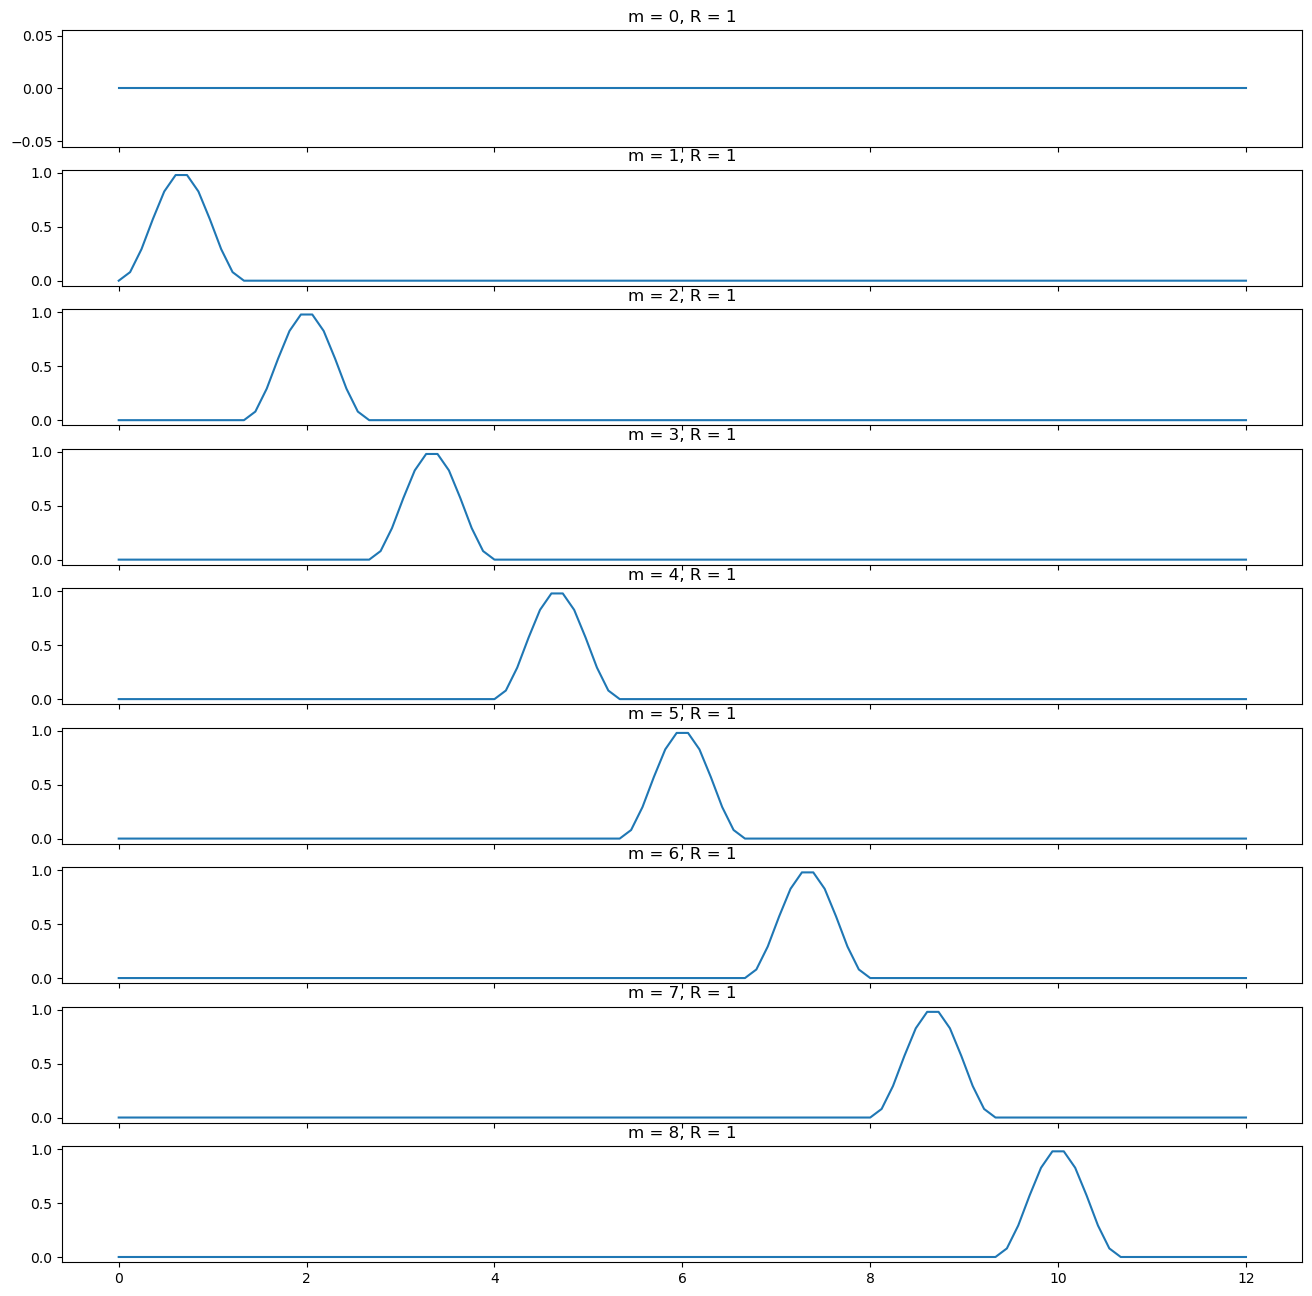

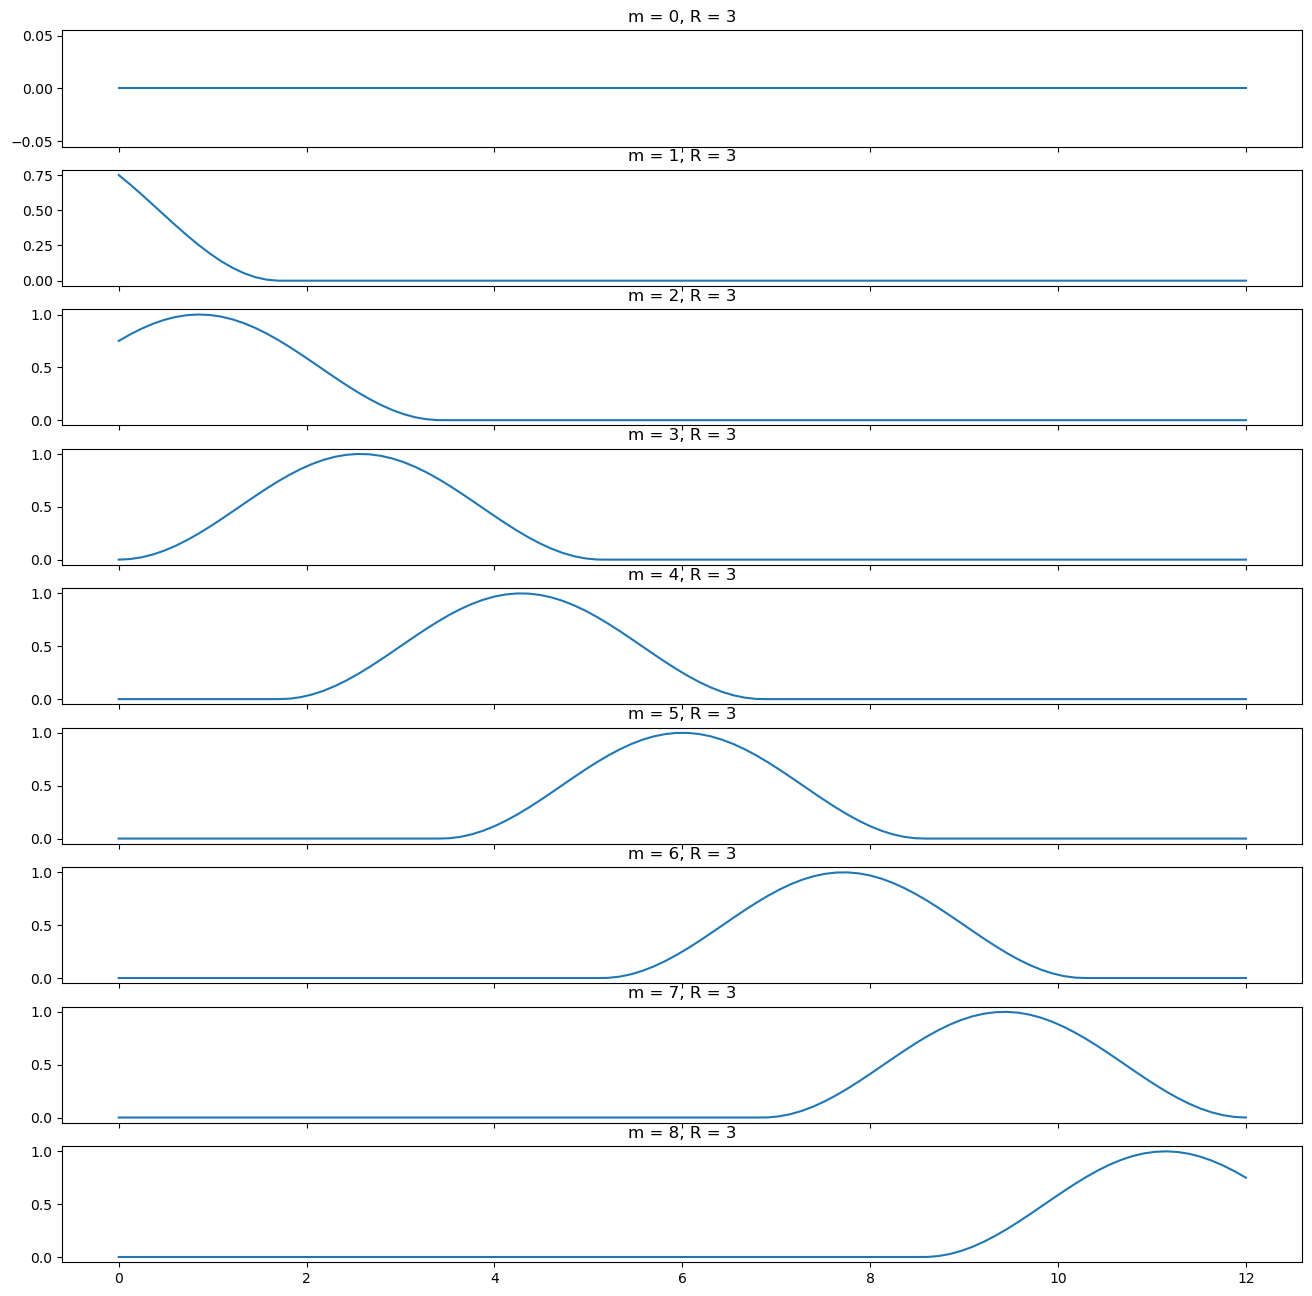

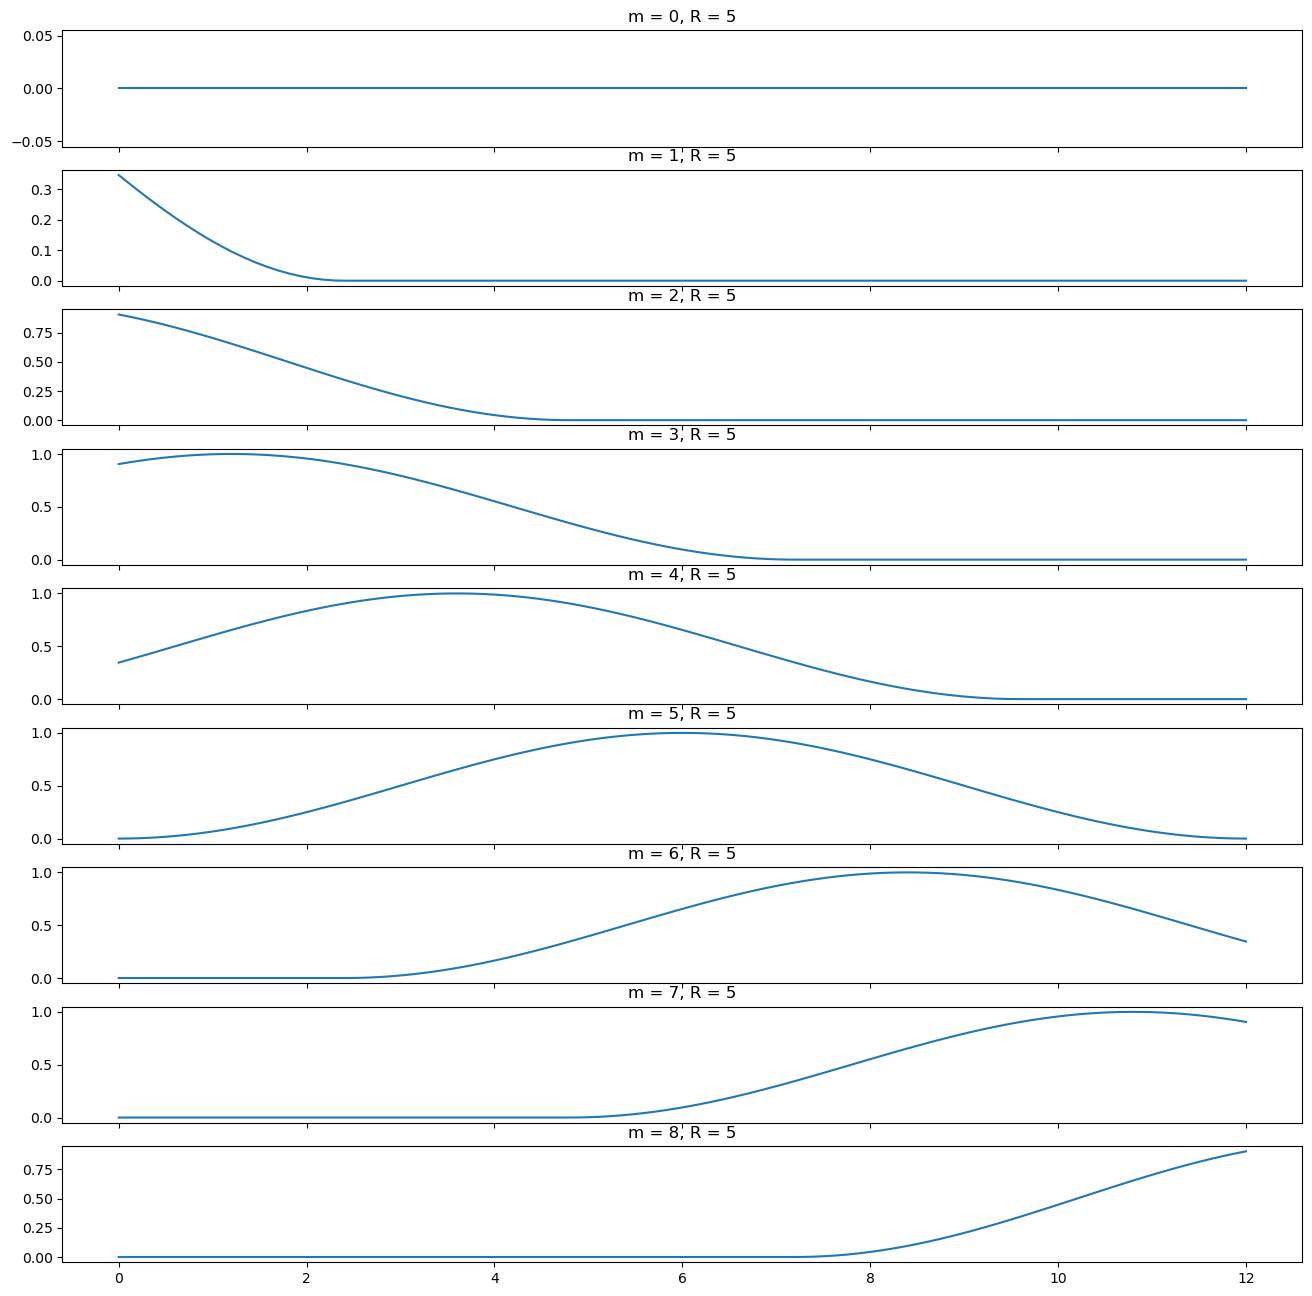

In [47]:
M = 9
list_R = [1,3,5]
lambd_n = 12
lambdas = np.linspace(0, lambd_n, num=100)

for c,R in enumerate(list_R):
    fig, axs  =plt.subplots(nrows=M, figsize=(16,16), sharex=True)
    for m in range(M):
        a = lambd_n / (M + 1 - R)
        y = np.array( [ g_m(x, a, m, R) for x in lambdas] )
        axs[m].plot(lambdas, y)
        axs[m].set_title(f"m = {m}, R = {R}")
    plt.show()

# ax.plot(lambd, g_m(lambd, a, m,R))


# Question 4

In [286]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset

data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

Clean-up - remove stations where some temperature data is missing

In [287]:
# clean-up temperature data
# identify stations where some rows have value NaN in column t
all_stations_with_missing_values = data_df[data_df['t'].isna()==True]["numer_sta"]
stations_with_missing_values = all_stations_with_missing_values.unique()

stations_to_remove = []
for station_num in stations_with_missing_values:
    nom = stations_df[stations_df["Numéro"]==station_num]["Nom"].item()
    stations_to_remove.append(nom)
    print(f"{nom} - station number is {station_num}")
    
# NB : remove rows with NaN in column 't'...
# ... but NaNs may remain in columns tx, tn
data_df_clean = data_df[data_df["station_name"].isin(stations_to_remove)==False]

PLOUGONVELIN - station number is 29190001
PLOUDALMEZEAU - station number is 29178001
VANNES-MEUCON - station number is 56137001
ST NAZAIRE-MONTOIR - station number is 44103001
SIZUN - station number is 29277001
BATZ - station number is 29082001
CAMARET - station number is 29022001
BEG_MEIL - station number is 29058003


In [288]:
stations_avant = data_df["station_name"].unique()
print(f"Nombre de stations avant nettoyage : {len(stations_avant)}")

stations_apres = data_df_clean["station_name"].unique()
print(f"Nombre de stations avant nettoyage : {len(stations_apres)}")

Nombre de stations avant nettoyage : 55
Nombre de stations avant nettoyage : 47


In [291]:
# identify eligible stations (no NaN)
subset_stations_df = stations_df.loc[(stations_df["Nom"].isin(data_df_clean["station_name"].unique()))]

In [293]:
len(subset_stations_df)

47

Build Graph with distance matrix and exponential smoothing, so that the graph is connected and the average degree is at least 3.

In [294]:
# we'll reuse a lot of code from Tuto 6

data_df2 = data_df_clean.reset_index().drop("index", axis="columns")

# convert temperature from Kelvin to Celsius
data_df2["Temp"] = data_df2.t - 273.15  # temperature in Celsius

# convert pandas df to geopandas df
CRS = "EPSG:4326"
stations_gdf = geopandas.GeoDataFrame(
    subset_stations_df,
    geometry=geopandas.points_from_xy(subset_stations_df.Longitude, subset_stations_df.Latitude),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.0045 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.404)
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85,POINT (-3.46867 48.75533)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)


In [338]:
# TP6 - pivoting table to get a multivariate time series
temperature_df = data_df2.pivot(index="date", values="Temp", columns="station_name")

# some stations have no data for specific time : we drop the row
temperature_df.dropna(inplace=True)

# net
temperature_df.head()

station_name,ARZAL,AURAY,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,DINARD,GUERANDE,GUISCRIFF SA,ILE DE GROIX,...,SAINT-CAST-LE-G,SAINT-JOACHIM_SAE,SARZEAU SA,SIBIRIL S A,SPEZET,ST BRIEUC,ST-SEGAL S A,THEIX,TREGUNC,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 01:00:00,9.8,10.4,10.3,7.6,9.6,9.2,6.5,10.6,7.8,10.0,...,6.3,9.3,9.9,8.2,8.6,7.0,9.5,9.1,10.9,9.9
2014-01-01 02:00:00,9.7,10.0,11.2,7.7,9.1,9.4,6.5,10.2,8.4,9.5,...,6.4,9.5,9.2,8.5,8.6,7.5,9.4,9.4,10.6,9.6
2014-01-01 03:00:00,9.4,10.4,11.4,7.9,9.7,10.1,7.1,10.6,8.4,10.4,...,7.0,9.0,10.1,8.5,8.9,7.2,9.9,8.9,10.8,9.8
2014-01-01 04:00:00,9.8,10.8,11.4,8.8,9.8,10.2,7.6,10.6,8.9,10.8,...,7.7,9.9,10.5,9.1,9.4,7.6,10.0,9.6,11.0,10.2
2014-01-01 05:00:00,10.2,11.1,11.0,9.4,9.1,9.5,8.3,10.8,8.6,10.8,...,8.1,10.0,10.5,9.0,9.1,7.8,9.5,10.2,10.6,10.5


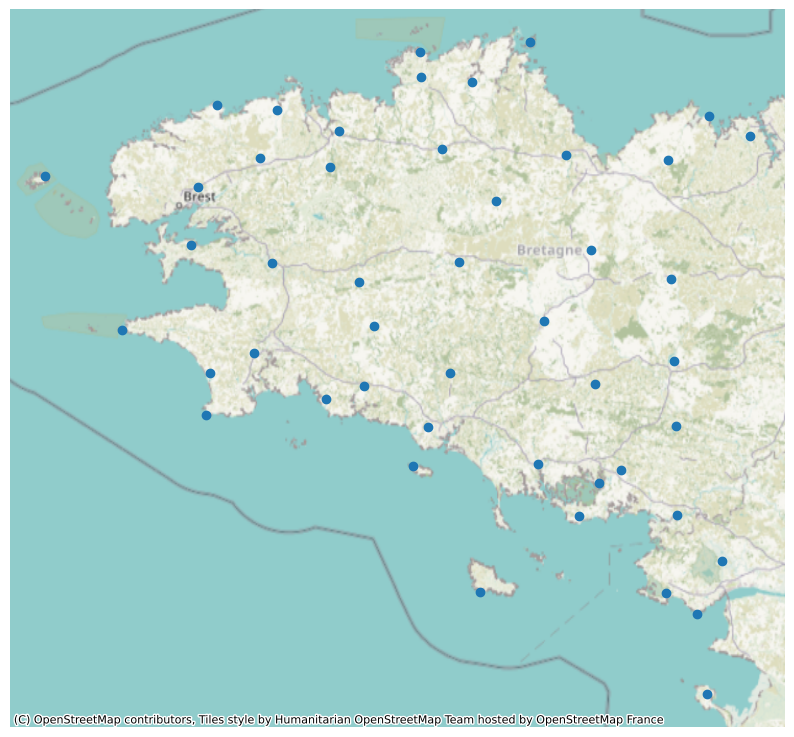

In [339]:
# map
#
# NB : la Bretagne ne s'est jamais aussi bien portée que quand elle était colonie Normande
#
# jdcjdr
#

import contextily as cx

ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

In [340]:
# TP6 - compute geodesic distances
from scipy.spatial.distance import pdist, squareform
from math import asin, cos, radians, sin, sqrt

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

stations_np = subset_stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

In [341]:
from pygsp import graphs

# exp sim function
def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

# check if graph is connected (eigenvalue=0 must have degree 1)
def is_connected(graph) -> bool:
    return (np.linalg.eigvalsh(graph.L.todense()) < 1e-6).sum()==1

In [342]:
# build graph
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.85

# iterate to get max threshold up to epsilon precision
def get_graph_metrics(epsilon):
    """Utility function to get threshold up to epsilon precision"""
    a = 0.1
    b = 1.0
    
    while (b-a)>epsilon:
        print(a, b)
        test_threshold = (a+b)/2
        adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, test_threshold))
        G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
        connected = is_connected(G_gaussian)
        average_degree = np.mean(G_gaussian.d)
        good = connected and (average_degree >= 6)
        print(f"Testing {test_threshold} : connected is {connected}, average degree is {average_degree >= 6}, overall is {good}")
        
        if good == True:
            # increase test_threshold
            a = test_threshold
        else:
            b = test_threshold
            
    return test_threshold

# build final graph
epsilon = 1e-3
threshold = get_graph_metrics(epsilon=epsilon)
print(f'\nFinal threshold, at {epsilon} precision, is {threshold:.4f}')
adjacency_matrix_gaussian = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)

print(f"The graph is {'not ' if not is_connected(G_gaussian) else ''}connected, has {G_gaussian.N} nodes, {G_gaussian.Ne} edges. Average degree is {average_degree:.2f}")

0.1 1.0
Testing 0.55 : connected is True, average degree is True, overall is True
0.55 1.0
Testing 0.775 : connected is True, average degree is True, overall is True
0.775 1.0
Testing 0.8875 : connected is False, average degree is False, overall is False
0.775 0.8875
Testing 0.83125 : connected is False, average degree is False, overall is False
0.775 0.83125
Testing 0.8031250000000001 : connected is False, average degree is True, overall is False
0.775 0.8031250000000001
Testing 0.7890625 : connected is False, average degree is True, overall is False
0.775 0.7890625
Testing 0.78203125 : connected is False, average degree is True, overall is False
0.775 0.78203125
Testing 0.778515625 : connected is True, average degree is True, overall is True
0.778515625 0.78203125
Testing 0.7802734375 : connected is True, average degree is True, overall is True
0.7802734375 0.78203125
Testing 0.78115234375 : connected is True, average degree is True, overall is True

Final threshold, at 0.001 precisi

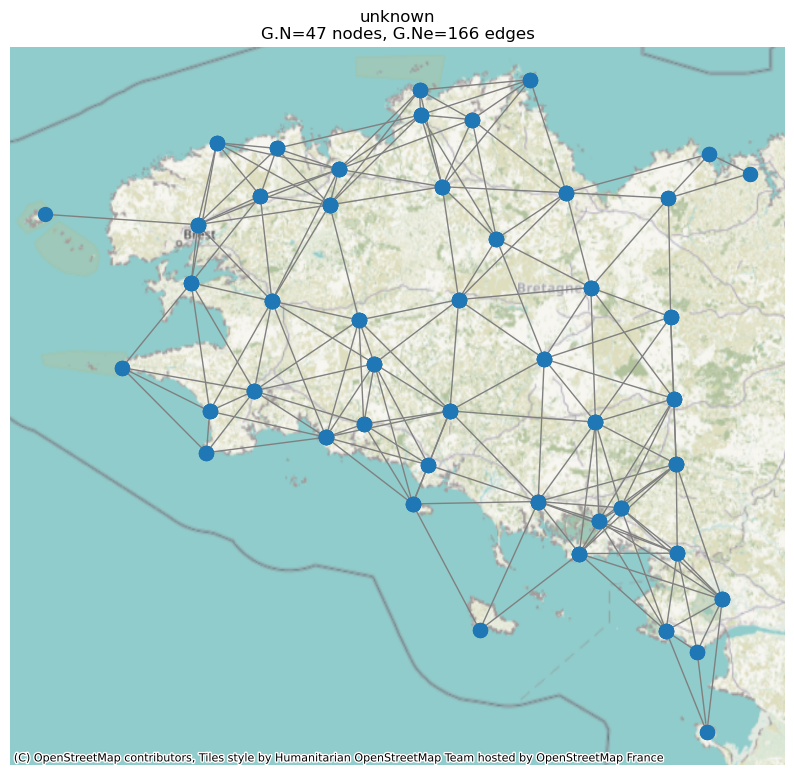

In [343]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax=ax)

Signal smoothness

We have seen that a signal smoothness is given by $S(x) = x^{T}Lx$, with high $S(x)$ meaning non-smooth $x$

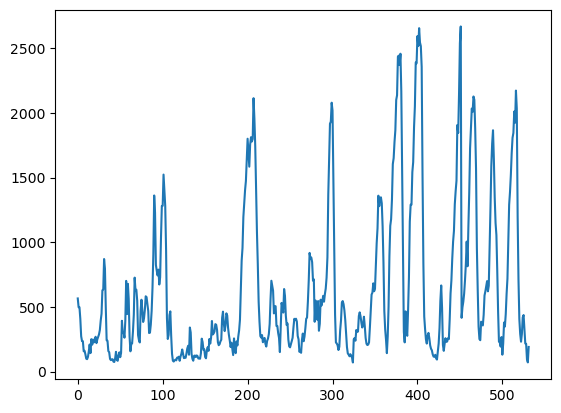

In [344]:
# the signal smoothness is given by 

smoothnesses = np.array([row.dot(G_gaussian.L.todense() @ row) for (_, row) in temperature_df.iterrows()])

plt.plot(smoothnesses)
plt.show()

In [349]:
print(f"Max smoothness is {np.max(smoothnesses)} for signal {np.argmax(smoothnesses)}")
print(temperature_df.iloc[np.argmax(smoothnesses),:])

Max smoothness is 2669.1311695335758 for signal 451
station_name
ARZAL                   1.4
AURAY                   2.5
BELLE ILE-LE TALUT     10.3
BIGNAN                  2.6
BREST-GUIPAVAS          9.0
BRIGNOGAN              10.7
DINARD                  3.8
GUERANDE                7.0
GUISCRIFF SA            3.9
ILE DE GROIX            9.7
ILE-DE-BREHAT           6.7
KERPERT                 4.8
LANDIVISIAU             8.5
LANNAERO                7.0
LANVEOC                 9.6
LORIENT-LANN BIHOUE     4.5
LOUARGAT                4.9
MERDRIGNAC              2.2
MORLAIX_AERO            6.9
NOIRMOUTIER EN          7.2
OUESSANT-STIFF         10.0
PLEUCADEUC              2.4
PLEYBER-CHRIST SA       7.5
PLOERMEL                3.2
PLOUAY-SA               0.9
PLOUGUENAST             2.9
PLOUMANAC'H             7.2
PLOVAN                 10.0
POMMERIT-JAUDY          6.0
PONTIVY                 2.7
PTE DE CHEMOULIN        8.6
PTE DE PENMARCH        10.0
PTE DU RAZ              9.9
QUIMPER    

In [350]:
print(f"Min smoothness is {np.min(smoothnesses)} for signal {np.argmin(smoothnesses)}")
print(temperature_df.iloc[np.argmin(smoothnesses),:])

Min smoothness is 70.45601933201317 for signal 324
station_name
ARZAL                  10.6
AURAY                  11.3
BELLE ILE-LE TALUT     11.2
BIGNAN                 10.4
BREST-GUIPAVAS         10.6
BRIGNOGAN              11.0
DINARD                 10.1
GUERANDE               11.0
GUISCRIFF SA            9.9
ILE DE GROIX           10.6
ILE-DE-BREHAT          10.6
KERPERT                 9.2
LANDIVISIAU            10.6
LANNAERO               10.5
LANVEOC                10.8
LORIENT-LANN BIHOUE    10.7
LOUARGAT                9.7
MERDRIGNAC             10.0
MORLAIX_AERO           10.4
NOIRMOUTIER EN         12.5
OUESSANT-STIFF         10.9
PLEUCADEUC             10.5
PLEYBER-CHRIST SA      10.2
PLOERMEL               10.7
PLOUAY-SA              10.6
PLOUGUENAST             9.3
PLOUMANAC'H            10.6
PLOVAN                 11.1
POMMERIT-JAUDY         10.7
PONTIVY                10.6
PTE DE CHEMOULIN       10.4
PTE DE PENMARCH        11.3
PTE DU RAZ             10.6
QUIMPER     

# Question 5

# Question 6

# Question 7